This script is used for register inference. Can also visualize clusters.

In [2]:
import numpy as np
import random
from scipy.special import softmax
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
#Take a list of (sequences, counts) and convert them into one-hot encodings
def encodeSequences(seqs):
    dic = {}
    v0 = np.zeros(20)
    for c, v in zip("ACDEFGHIKLMNPQRSTVWY", np.eye(20)):
        dic[c] = v
    encSeqs = []
    for seq, ct in seqs:
        # Pad entries to allow shifting to work - padding at C-terminal end 
        encSeqs.append(( np.array([dic[c] for c in seq] + [v0]*(n_padded-(15-n_clusters+1))), ct )) 

    return encSeqs

# Updates all p1 positions
def iteration(model, seqs, beta, background):
    p1selection = list(range(0,n_clusters)) #No trash cluster
    for seqinfo in seqs:
        seq, n, shift = seqinfo
        if shift != -1:
            model -= seq[shift:shift+n_padded] * n
        sums = np.sum(model, axis = 1).reshape((-1,1))
        pwm = np.log(model/sums) - background
        p = [] #[0]  #No trash cluster
        
        for i in range(n_clusters):
            p.append( n * beta * np.sum( pwm * seq[i:i+n_padded] ) )
        shift = random.choices( p1selection, weights = softmax(p), k = 1 )[0]
        seqinfo[2] = shift
        if shift != -1:
            model += seq[shift:shift+n_padded] * n

# Updates all p1 positions with beta = inf (0 temperature)
def finalIteration(model, seqs, background):
    p1selection = list(range(0,n_clusters))
    for seqinfo in seqs:
        seq, n, shift = seqinfo
        if shift != -1:
            model -= seq[shift:shift+n_padded] * n
        sums = np.sum(model, axis = 1).reshape((-1,1))
        pwm = np.log(model/sums) - background
        p = [] #make empty to start this time
        for i in range(n_clusters):
            p.append( n * np.sum( pwm * seq[i :i+n_padded ] ) ) 
            
        shift = p1selection[np.argmax(p)]
        seqinfo[2] = shift
        if shift != -1:
            model += seq[shift:shift+n_padded] * n
        
            
def reportScore(model, seqs, background):
    sums = np.sum(model, axis = 1).reshape((-1,1))
    pwm = np.log(model/sums) - background
    
    score = 0
    for seq, n, shift in seqs:
        if shift != -1:
            score += np.sum( pwm * seq[shift:shift+n_padded] ) * n
            
    pd.DataFrame(pwm).to_csv('{}_{}_pwm.csv'.format(save_prefix, allele)) #overwrites until the final time and save pwm
    pd.DataFrame(model).to_csv('{}_{}_model.csv'.format(save_prefix, allele))
    return score
    
# seqs : list of (sequence, count) tuples.
# iterations : number of iterations to carry out (not including the final iteration)
# betamin, betamax : the first iteration will be done with beta=betamin, and one before the final iteration
# with beta=betamax. Beta is linearly interpolated linearly in between
# Beta is the inverse of temprature, so this simulates cooling.


def alignSequences(seqs, iterations, betamin, betamax):

    model = np.ones((n_padded,20))
    result = []
    assignments = np.random.randint(0,n_clusters,len(seqs)) #GOT RID OF TRASH CLUSTER (no -1)
    for (seq, n), shift in zip(encodeSequences(seqs), assignments):
        if shift != -1:
            model += seq[shift:shift+n_padded] * n
        result.append([seq, n, shift])
    background = np.log(1/20)
    
    betas = np.linspace(betamin,betamax,iterations)
    for i,beta in enumerate(betas):
        iteration(model, result, beta, background)        
        print ("Iteration {}, beta = {}, score = {}".format(i, beta, reportScore(model, result, background)))
    
    finalIteration(model, result, background)
    print ("Final iteration, score = {}".format(reportScore(model, result, background)))
    
    return result

def readInput(filename):
    seqs = []
    with open(filename, 'rt') as fin:
        for i, line in enumerate(fin):
            if i == 0: continue
            seq, ct = line.split(',')
            seqs.append((seq, int(ct)))
    return seqs

def readInput_alt(df):
    #Alternative: using dataframes and ignoring peptide counts
    #ignoring counts - i.e. count=1
    seqs = []
    for entry in df['name']:
        seq, ct = entry, 1
        seqs.append((seq, int(ct)))
    return seqs


def writeOutput(filename, alignment, sequences):
    lines = ["sequence,count,P1"]
    for (_,ct,p1), (seq,_) in zip(alignment, sequences):
        lines.append("{},{},{}".format(seq,ct,p1))
    with open(filename, 'wt') as fout:
        fout.write('\n'.join(lines))

In [4]:
#functions to make sequence logos

global_aa = list("ACDEFGHIKLMNPQRSTVWY")
polars = set(['G', 'S', 'T', 'Y', 'C', 'Q', 'N'])
basics = set(['K', 'R', 'H'])
acids = set(['D', 'E'])
#The rest are hydrophobic and black

def readimg(fname, col):
    arr = plt.imread(fname)
    newarr = np.zeros(shape=(len(arr), len(arr[0]), 4), dtype = "uint8")
    uparr = np.zeros(shape=(len(arr), len(arr[0]), 4), dtype = "uint8")
    downarr = np.zeros(shape=(len(arr), len(arr[0]), 4), dtype = "uint8")
    for x in range(len(arr)):
        for y in range(len(arr[0])):
            newarr[x][y][3] = 255 - arr[x][y][0] * 255
            newarr[x][y][0] = col[0]
            newarr[x][y][1] = col[1]
            newarr[x][y][2] = col[2]
    return newarr

imdic = {}
updic = {}
downdic = {}
for i in range(26):
    c = chr(i + ord('A'))
    col = (0,0,0)
    if c in polars:
        col = (0,192,0)
    elif c in basics:
        col = (24,32,255)
    elif c in acids:
        col = (255,0,0)
        
    imdic[c] = readimg("{}_crop.png".format(c), col)
    #directory with images of letters in it
    
def drawColumn(ax, seqs, hgts, shift, wide):
    i = 0
    for i,x in enumerate(range(1,16)):
        l = x-wide/2 + shift
        r = x+wide/2 + shift
        b = 0
        for c,p in seqs[i][::-1]:
            hgt = hgts[i] * p
            t = b + hgt
            if hgt == 0:
                b = t
                continue
                
            mgn = hgt * 0
            ax.imshow(imdic[c], aspect = "auto", extent = (l,r,b+mgn,t-mgn), interpolation = 'bilinear')
            b = t

    ax.set_xticks(range(1,16))
    ax.set(xlim = (0,16), ylim = (0,max(hgts)*1.1))

    
def drawLogo(seqlist):
    fig, ax = plt.subplots(1,1,figsize=(10, 6))
    w = 0.8#0.25
    ws = 0.28
    h = 0
    for i in range(-1,0):
        fractions, heights = seqlist[i+1]
        drawColumn(ax, fractions, heights, ws*(i+1), w)
        h = max(h, max(heights))
    ax.set(ylim = (0, 1.1*h), xlim = (0.5, 15.5))
    
    xtc = []
    xlab = []
    for i in range(1,16):
        for j in range(0,1):
            pos = i + j*ws
            lab = "P{}".format(i)
            xtc.append(pos)
            xlab.append(lab)
    ax.set_xticks(xtc)
    ax.set_xticklabels(xlab, rotation=270)
    ax.set_ylabel("Bits")
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.title(str(cluster))

In [5]:
# Process data
save_prefix = 'test-v4'

n_padded = 9 #size of kernel (dimension in model)
n_clusters = 11 #number of different clusters that can assign to

##
data = pd.read_csv('../twist_covid_filtered+normalized_counts.csv').fillna(0)
data.drop(columns='Unnamed: 0',inplace=True)
data.drop(columns='Unnamed: 0.1',inplace=True)
data=data[data['doped_match']!='match'] #keep only covid peptides

##
for allele in ['401','402','404']:

    doped_positive = (data['count_ doped-{} post-R3 '.format(allele)]>=10)
    undoped_positive = (data['frac_ undoped-{} post-R2 - positive '.format(allele)]>data['frac_ undoped-{} post-R1 - positive '.format(allele)])

    data['hit d+u'] = doped_positive & undoped_positive

    sequences = readInput_alt(data[data['hit d+u']==True])
    alignment = alignSequences(sequences, 60, 0.05, 1)
    fname = "{}_{}_twist_covid_filtered+normalized_counts_{}.csv".format(save_prefix,allele,'d+u')
    writeOutput(fname, alignment, sequences)

/Users/brooke/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (2,40,42,43,47,51,55,60) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Iteration 0, beta = 0.05, score = 2241.2185119703545
Iteration 1, beta = 0.06610169491525424, score = 2297.840258930908
Iteration 2, beta = 0.08220338983050848, score = 2315.290218858556
Iteration 3, beta = 0.09830508474576272, score = 2337.9428112184937
Iteration 4, beta = 0.11440677966101695, score = 2369.172860961456
Iteration 5, beta = 0.13050847457627118, score = 2308.1794620088626
Iteration 6, beta = 0.14661016949152544, score = 2445.0243937291425
Iteration 7, beta = 0.16271186440677965, score = 2445.926565180155
Iteration 8, beta = 0.1788135593220339, score = 2436.321806534749
Iteration 9, beta = 0.19491525423728812, score = 2532.6555020436317
Iteration 10, beta = 0.21101694915254238, score = 2503.626212529908
Iteration 11, beta = 0.22711864406779658, score = 2473.857803931757
Iteration 12, beta = 0.24322033898305084, score = 2528.1196008690144
Iteration 13, beta = 0.2593220338983051, score = 2629.589567186652
Iteration 14, beta = 0.2754237288135593, score = 2637.0307261903877
I

Iteration 2, beta = 0.08220338983050848, score = 2373.609204737503
Iteration 3, beta = 0.09830508474576272, score = 2509.8027498832353
Iteration 4, beta = 0.11440677966101695, score = 2442.479683028148
Iteration 5, beta = 0.13050847457627118, score = 2582.4220980725468
Iteration 6, beta = 0.14661016949152544, score = 2518.2688868488735
Iteration 7, beta = 0.16271186440677965, score = 2550.875363316872
Iteration 8, beta = 0.1788135593220339, score = 2635.5400076562855
Iteration 9, beta = 0.19491525423728812, score = 2616.816682582826
Iteration 10, beta = 0.21101694915254238, score = 2661.1000792926893
Iteration 11, beta = 0.22711864406779658, score = 2671.8336558365686
Iteration 12, beta = 0.24322033898305084, score = 2701.152886282907
Iteration 13, beta = 0.2593220338983051, score = 2763.376890345441
Iteration 14, beta = 0.2754237288135593, score = 2845.1967219934622
Iteration 15, beta = 0.29152542372881357, score = 2816.9185303207723
Iteration 16, beta = 0.3076271186440678, score = 27

Register 0: 161 sequences; 6.53%
Register 1: 237 sequences; 9.61%
Register 2: 227 sequences; 9.2%
Register 3: 238 sequences; 9.65%
Register 4: 231 sequences; 9.36%
Register 5: 279 sequences; 11.31%
Register 6: 237 sequences; 9.61%
Register 7: 266 sequences; 10.78%
Register 8: 271 sequences; 10.99%
Register 9: 202 sequences; 8.19%
Register 10: 118 sequences; 4.78%


/Users/brooke/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Register 0: 115 sequences; 6.8%
Register 1: 176 sequences; 10.41%
Register 2: 187 sequences; 11.07%
Register 3: 181 sequences; 10.71%
Register 4: 171 sequences; 10.12%
Register 5: 195 sequences; 11.54%
Register 6: 173 sequences; 10.24%
Register 7: 193 sequences; 11.42%
Register 8: 150 sequences; 8.88%
Register 9: 98 sequences; 5.8%
Register 10: 51 sequences; 3.02%
Register 0: 119 sequences; 5.68%
Register 1: 191 sequences; 9.12%
Register 2: 216 sequences; 10.32%
Register 3: 219 sequences; 10.46%
Register 4: 208 sequences; 9.93%
Register 5: 224 sequences; 10.7%
Register 6: 201 sequences; 9.6%
Register 7: 243 sequences; 11.6%
Register 8: 223 sequences; 10.65%
Register 9: 157 sequences; 7.5%
Register 10: 93 sequences; 4.44%


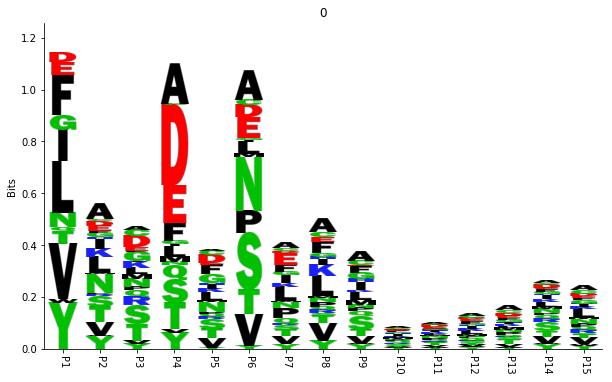

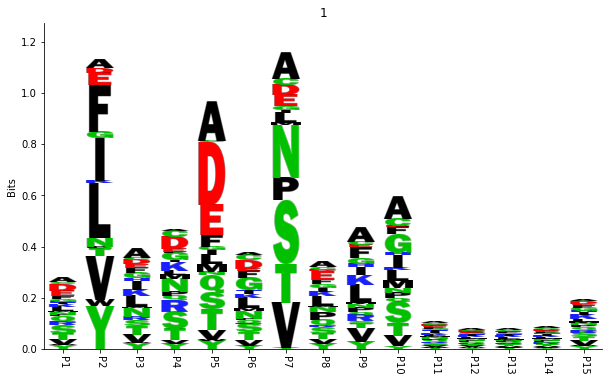

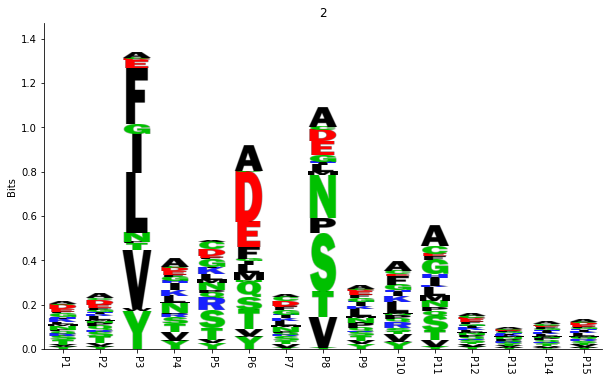

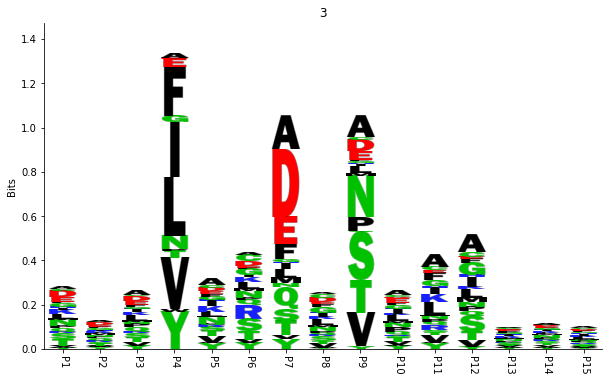

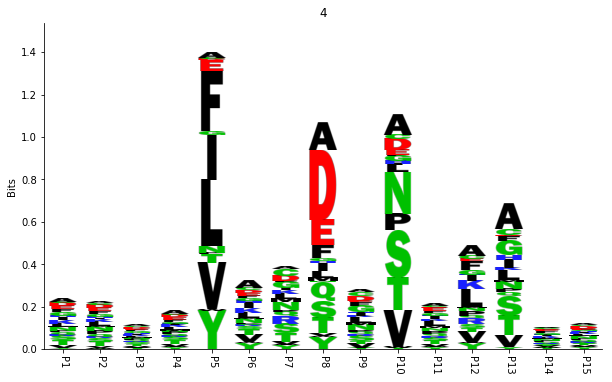

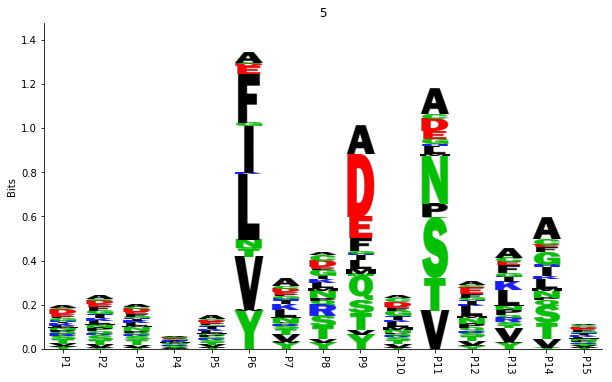

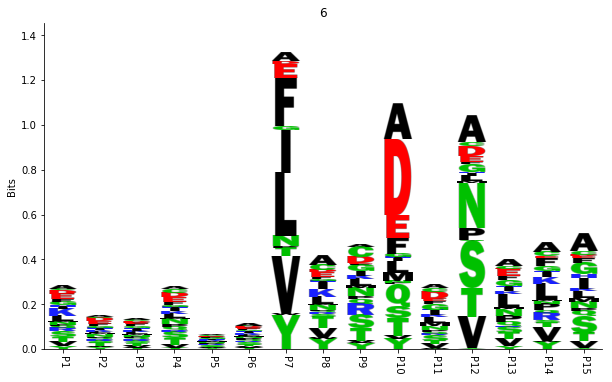

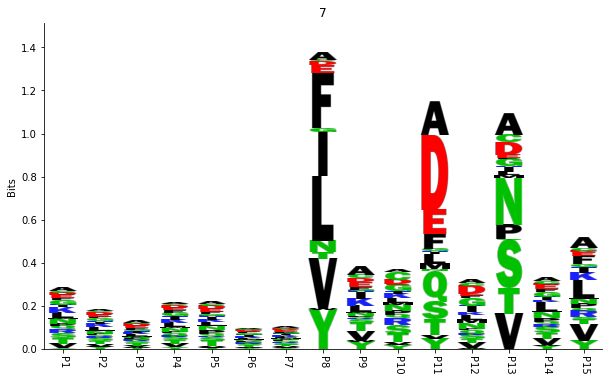

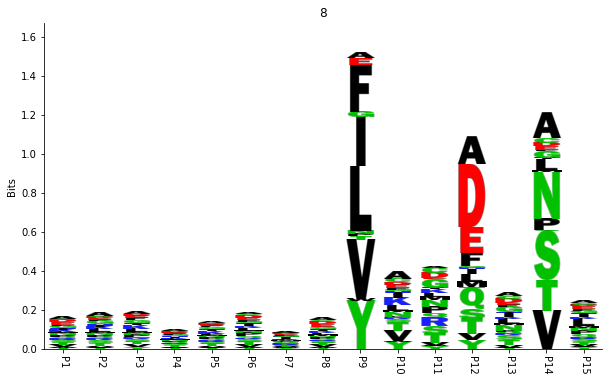

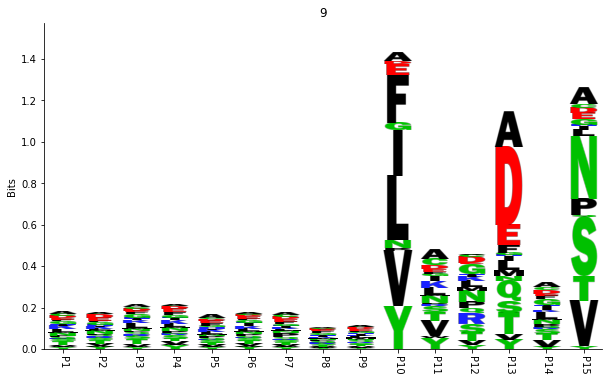

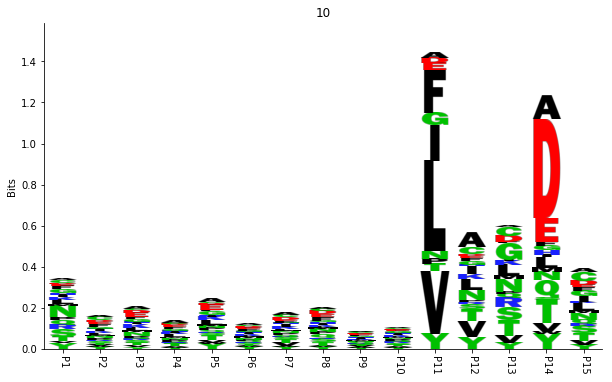

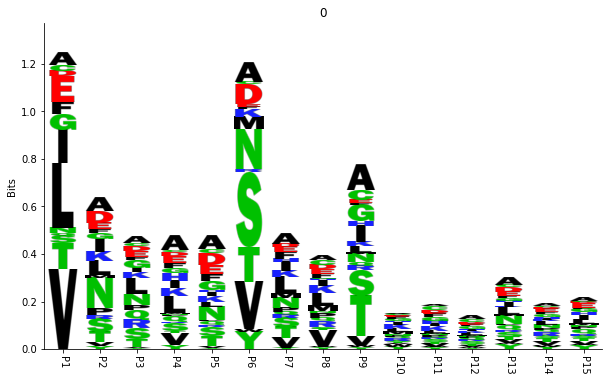

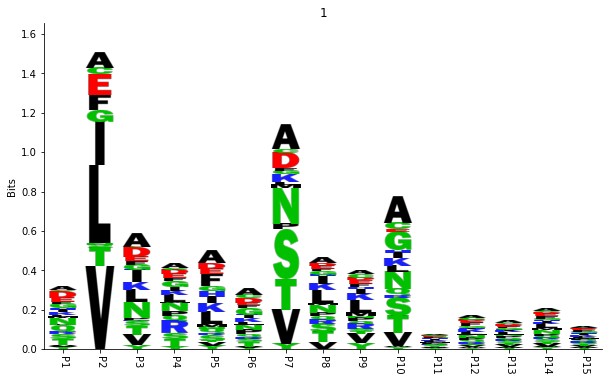

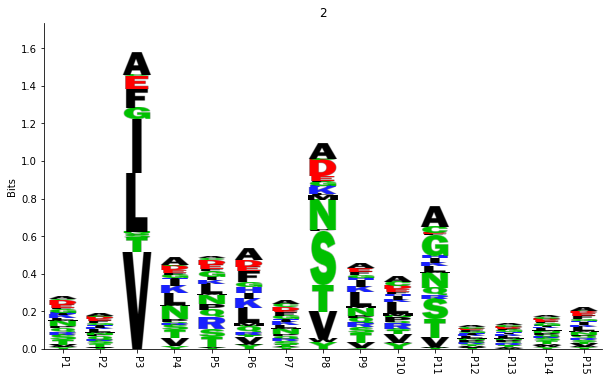

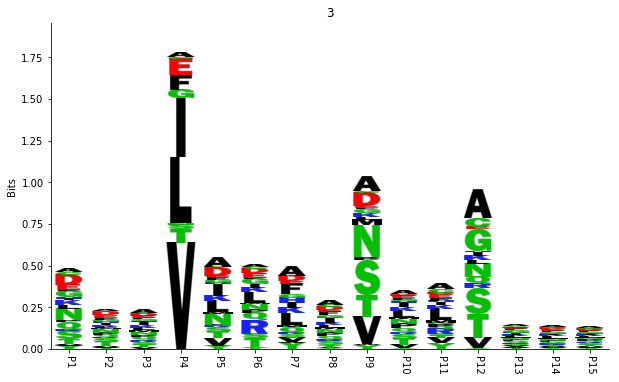

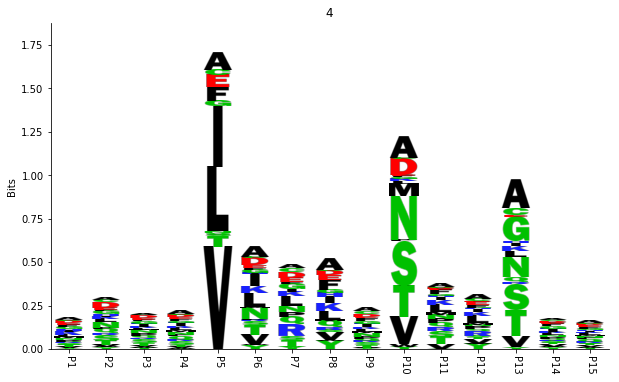

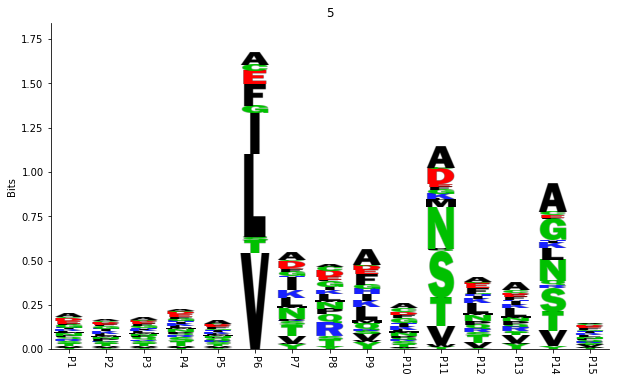

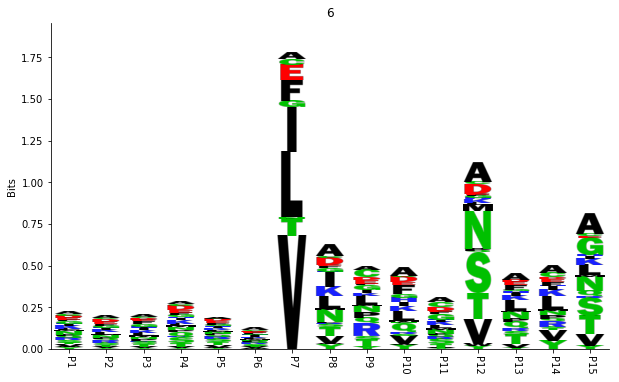

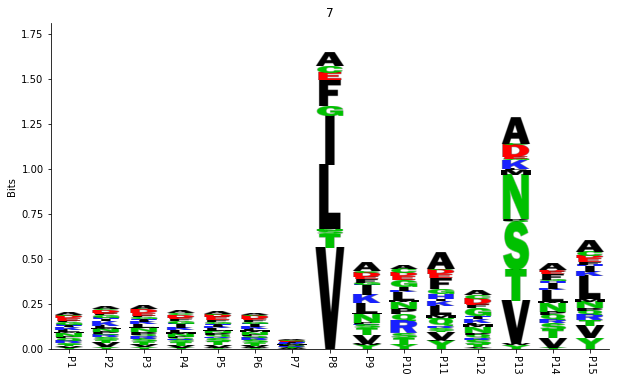

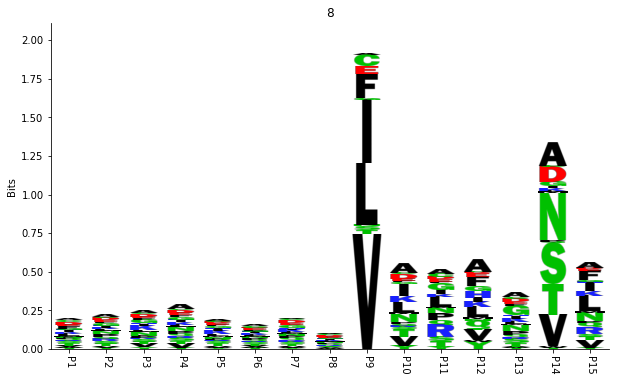

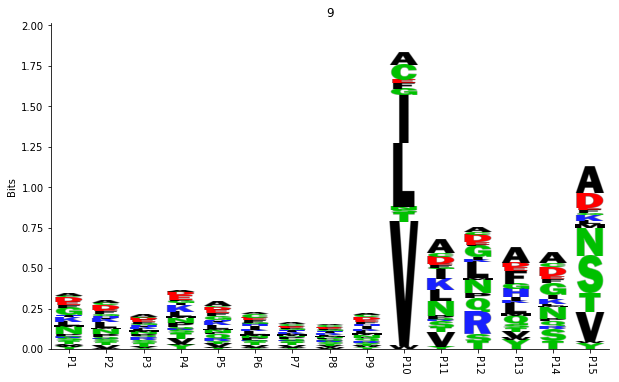

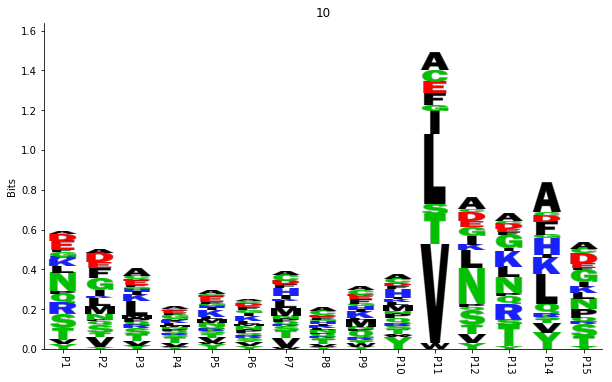

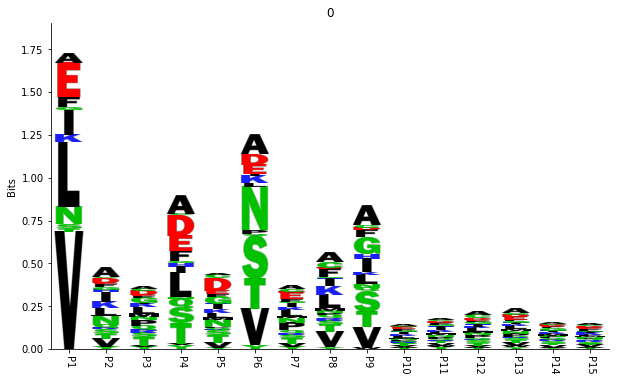

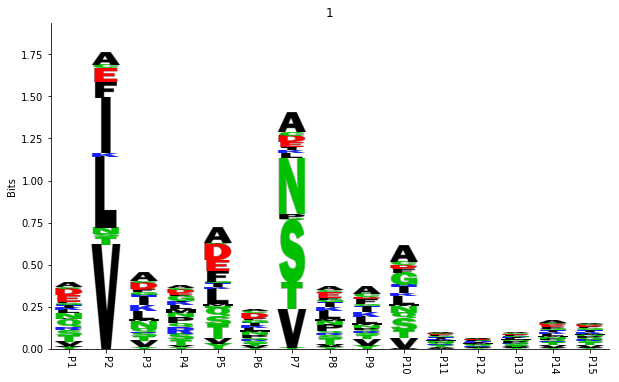

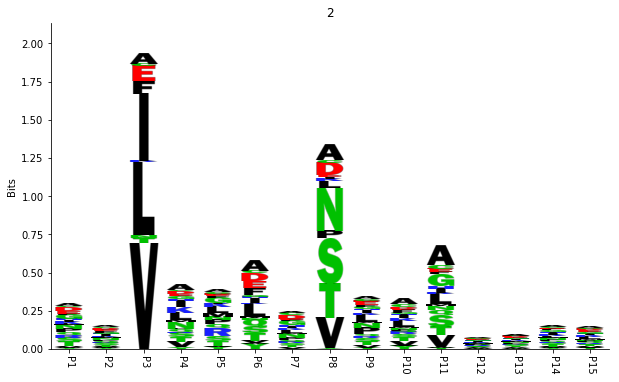

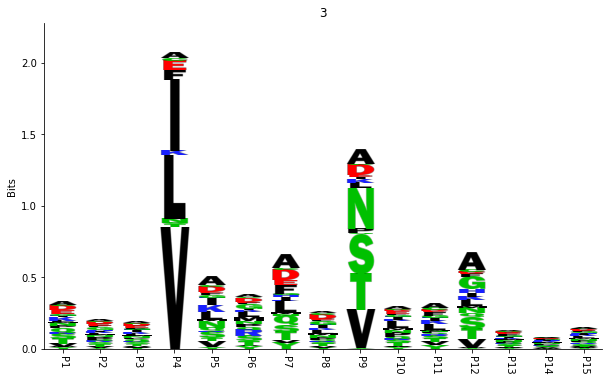

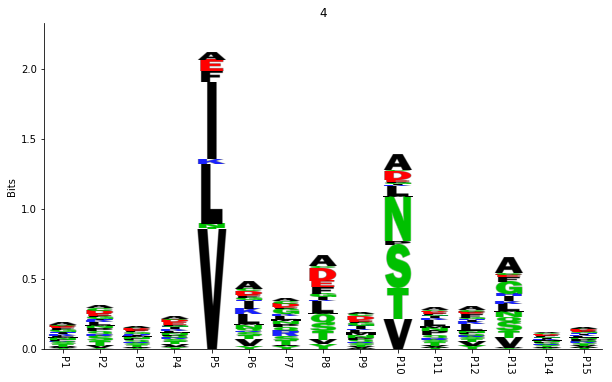

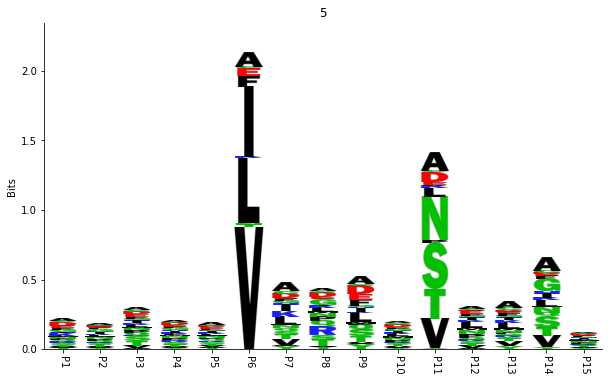

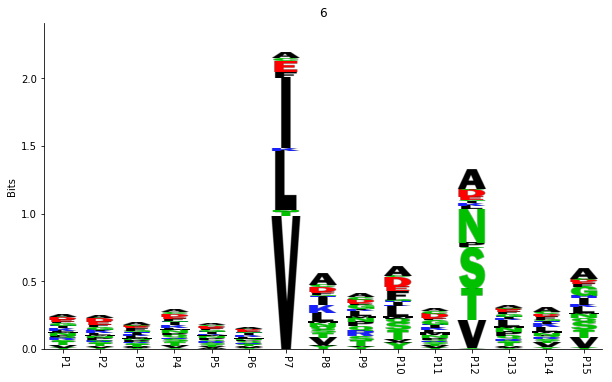

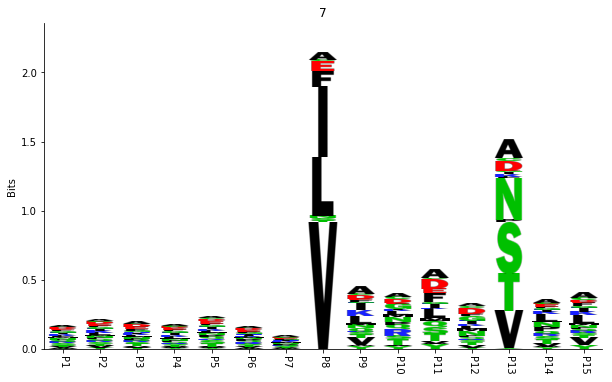

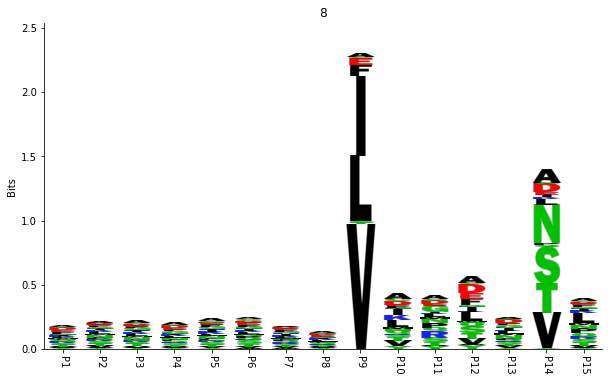

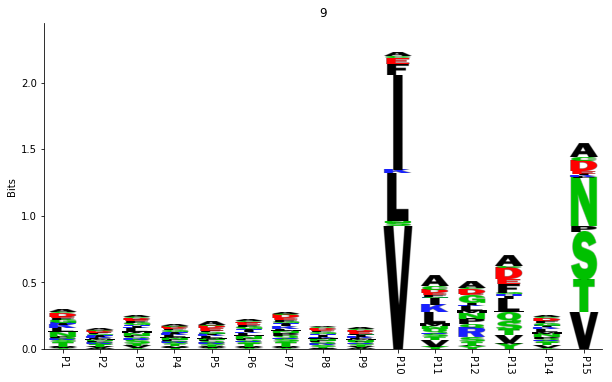

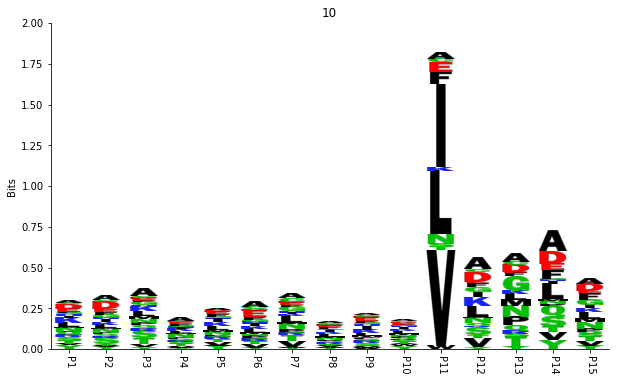

In [6]:
## Visualize

# Each sequence is a tuple of (fraction data, height data)
# Fraction data is a list of 9 tuples of (amino acid, relative height)
# Height data is a list of 9 numbers denoting height of the column 

#re-imports data
for allele in ['401','402','404']:
    
    fname = "{}_{}_twist_covid_filtered+normalized_counts_{}.csv".format(save_prefix,allele,'d+u')
    data_clustered = pd.read_csv(fname)

    for cluster in range(0,n_clusters):
        data_sub = data_clustered[data_clustered['P1']==cluster]

        frac_list = []    
        height_list = []

        for j in range(15): #iterate over positions
            temp = []
            height = np.log2(20)
            for c in global_aa:
                frac = np.sum(data_sub['sequence'].str[j]==c)/len(data_sub)
                temp.append((c,frac))
                if frac != 0:
                    height += frac*np.log2(frac)
            height_list.append(height)
            frac_list.append(temp) 

        drawLogo([(frac_list, height_list)])

    #Count the number of sequences in each register
    for p1 in list(range(0,n_clusters)):
        n = np.sum(data_clustered['P1']==p1)
        frac = n/len(data_clustered)
        print("Register {}: {} sequences; {}%".format(p1,n,round(frac*100,2))) 